In [136]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


from empmap.poly_fit import mu_fit_selector

In [137]:
from matplotlib import rcParams
from cycler import cycler

rcParams['figure.titlesize']=16
rcParams['font.size']=12
rcParams['axes.titlesize']=16
rcParams['axes.labelsize']=24
rcParams['figure.labelsize']=28
rcParams['xtick.labelsize']=16
rcParams['ytick.labelsize']=16
rcParams['axes.linewidth'] = 1.5
rcParams['lines.markersize']=10
rcParams['lines.linewidth']=2.5
rcParams['xtick.major.size'] = 5
rcParams['xtick.major.width'] = 1
rcParams['ytick.major.size'] = 5
rcParams['ytick.major.width'] = 1
rcParams['xtick.bottom'] = True
rcParams['xtick.top']=True
rcParams['xtick.direction']="in"
rcParams['ytick.left'] = True
rcParams['ytick.right'] = True
rcParams['ytick.direction']="in"
rcParams['svg.fonttype'] = 'none'

Pull in the fitting functions we will need

In [138]:
quartic = mu_fit_selector(6)
cubic = mu_fit_selector(5)
r0 = 1.0

In [139]:
def poly_to_deriv_param(popt):
    order = len(popt)
    deriv = np.zeros(order-1)
    for i in range(1, order):
        deriv[i-1] = popt[i]*i
    return deriv

Load the data into the notebook

In [140]:
polar = pickle.load(open('pols_0_to_100.pckl', 'rb'))
eOHs = pickle.load(open('eOHs_0_to_100.pckl', 'rb'))
proj = pickle.load(open('proj_0_to_100.pckl', 'rb'))

In [141]:
pol_labels = ['xx', 'yx', 'yy', 'zx', 'zy', 'zz']

Generate the rOH values

In [142]:
rOH = np.linspace(0.65, 2.25, 16)
xvals = np.linspace(0.65, 2.25, 100)

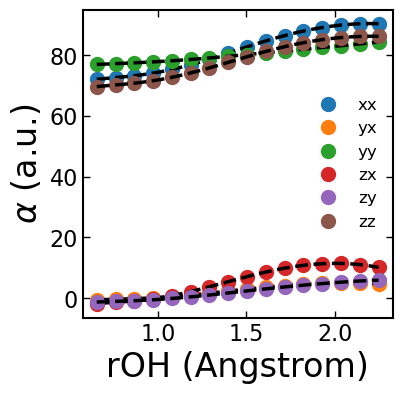

In [143]:
fig = plt.figure(figsize=(4,4))
for i in range(6):
    popt, pcov = curve_fit(quartic, rOH, polar[0][:,i])
    yvals = quartic(xvals, *popt)
    plt.plot(rOH, polar[0][:,i], 'o', label=pol_labels[i])
    plt.plot(xvals, yvals, '--', color='black')

plt.legend(frameon=False)
plt.xlabel("rOH (Angstrom)")
plt.ylabel("$\\alpha$ (a.u.)")
plt.show()

In [144]:
def numerical_derivative(x, y):
    return np.gradient(y, x)

10.591516513835742
3.54858012561942
3.321009298475356
8.98653162039858
3.729421537144395
9.889137267807655


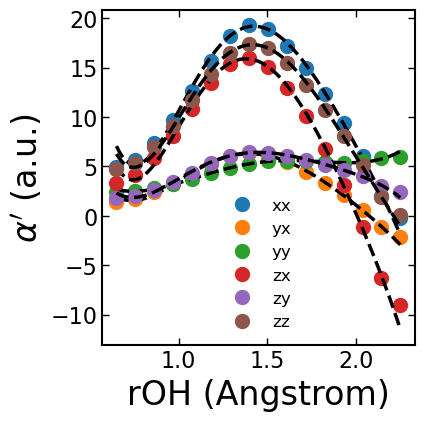

In [145]:
fig = plt.figure(figsize=(4,4))
for i in range(6):
    popt, pcov = curve_fit(quartic, rOH, polar[0][:,i])
    deriv = numerical_derivative(rOH, polar[0][:,i])
    dpopt = poly_to_deriv_param(popt)
    yvals = cubic(xvals, *dpopt)
    plt.plot(rOH, deriv, 'o', label=pol_labels[i])
    plt.plot(xvals, yvals, '--', color='black')
    print(cubic(r0, *dpopt))
plt.legend(frameon=False)
plt.tight_layout()
plt.xlabel("rOH (Angstrom)")
plt.ylabel("$\\alpha'$ (a.u.)")

plt.show()

In [146]:
def grab_pol_deriv(istep, pol_type):
    popt, _ = curve_fit(quartic, rOH, polar[istep][:,pol_type])
    dpopt = poly_to_deriv_param(popt)
    return cubic(r0, *dpopt)

In [147]:
proj_values = np.array(list(proj.values()))
eoh_values = np.array(list(eOHs.values()))
eoh_values.shape

(100, 3)

In [148]:
alpha_derivs = {}
for i in range(6):
    alpha_derivs[i] = [grab_pol_deriv(j, i) for j in range(0,100)]

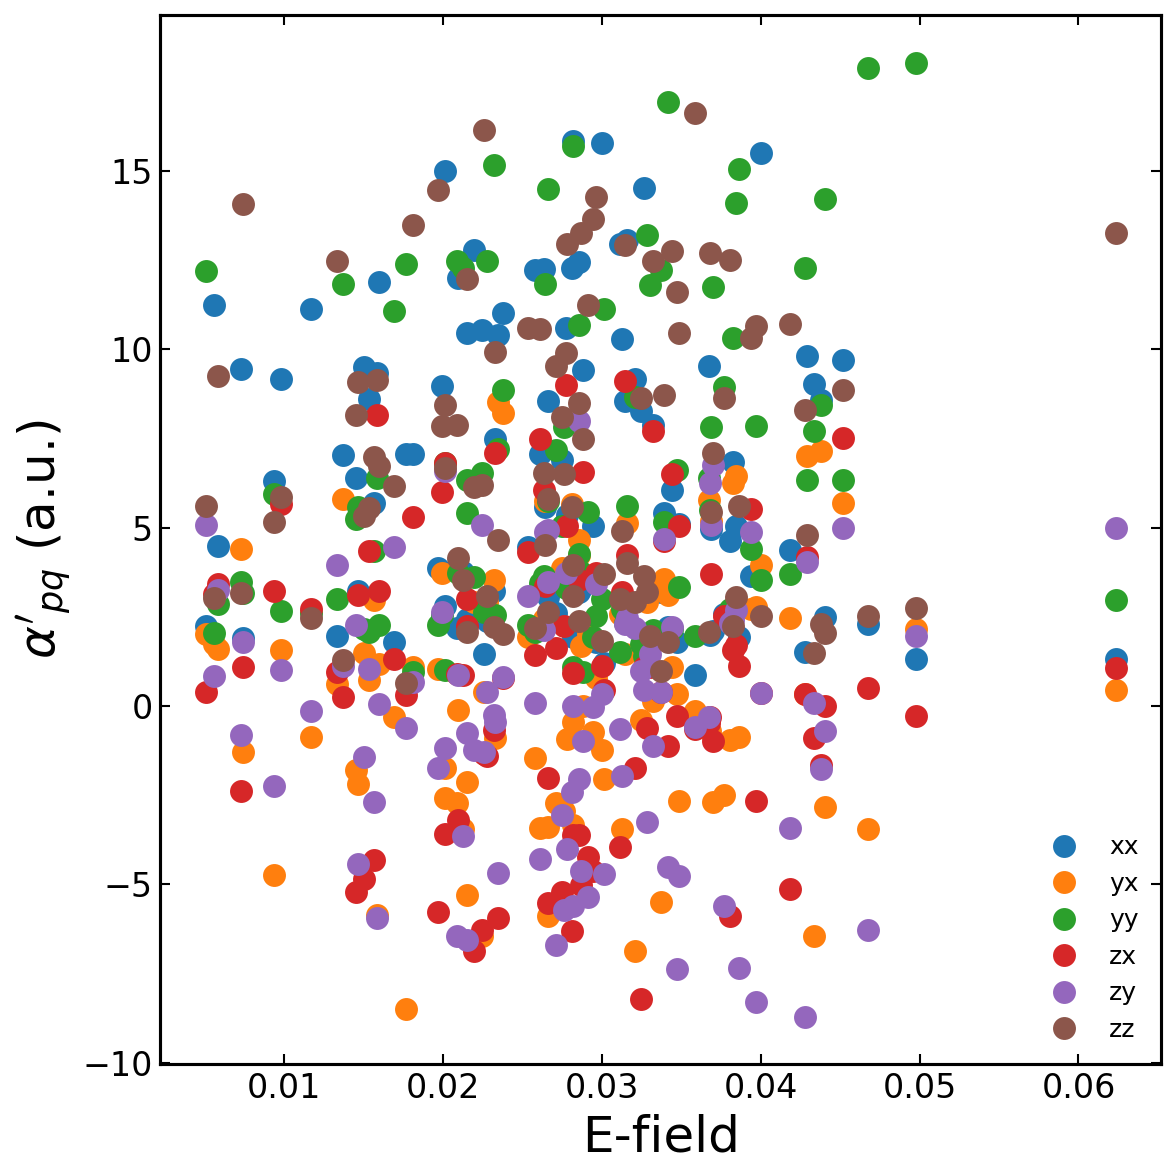

In [149]:
fig = plt.figure(figsize=(8,8),dpi=150) 
for i in range(6):
    plt.plot(proj_values, alpha_derivs[i], 'o', label=pol_labels[i])
plt.xlabel("E-field")
plt.ylabel("$\\alpha'_{pq}$ (a.u.)")
plt.tight_layout()
plt.legend(frameon=False)
plt.show()

Clearly none of these components are correlated with the electric field

Lets try instead to get the angle w.r.t. the z axis.

In [150]:
z_axis = [0,0,1]
costheta = np.dot(z_axis, eoh_values.T)

In [151]:
def alpha_parallel(azz, costheta):
    return 5.6*azz/(1 + 4.6*costheta[:,np.newaxis]**2)

In [152]:
azzs = np.array(list([pol[:,5] for pol in polar.values()]))
azzs.shape
apar = alpha_parallel(azzs, costheta)

In [153]:
def grab_apol_deriv(apol):
    popt, _ = curve_fit(quartic, rOH, apol)
    dpopt = poly_to_deriv_param(popt)
    return cubic(r0, *dpopt)

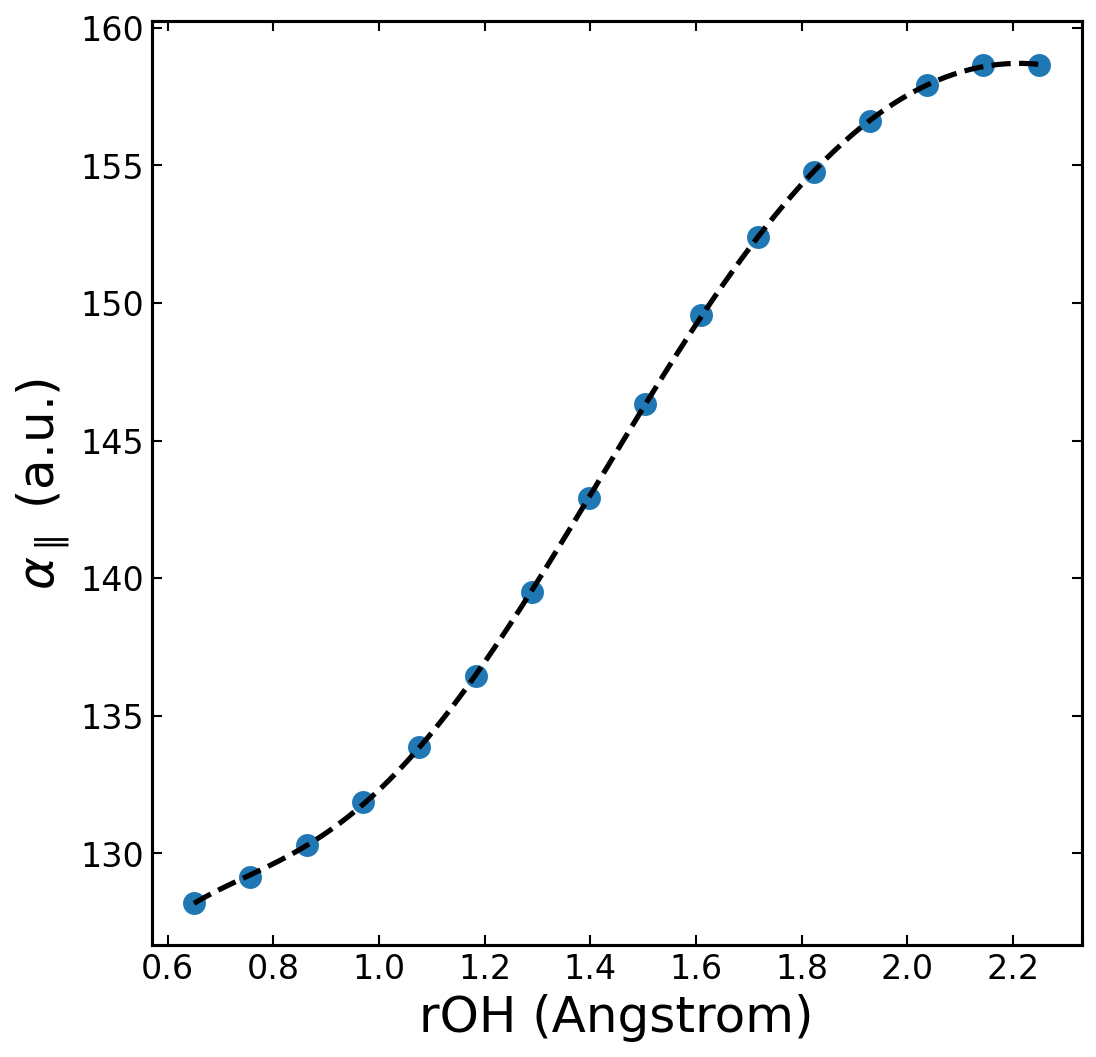

In [154]:
fig = plt.figure(figsize=(8,8),dpi=150)
popt, pcov = curve_fit(quartic, rOH, apar[0])
yvals = quartic(xvals, *popt)

plt.plot(rOH, apar[0], 'o', label='0')
plt.plot(xvals, yvals, '--', color='black')
plt.xlabel("rOH (Angstrom)")
plt.ylabel("$\\alpha_\parallel$ (a.u.)")
plt.show()

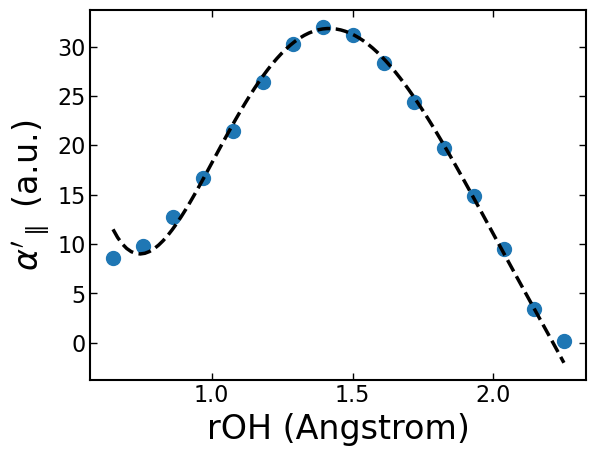

In [155]:
dpopt = poly_to_deriv_param(popt)
yvals = cubic(xvals, *dpopt)
plt.plot(rOH, numerical_derivative(rOH, apar[0]), 'o', label='0')
plt.plot(xvals, yvals, '--', color='black')
plt.xlabel("rOH (Angstrom)")
plt.ylabel("$\\alpha'_\parallel$ (a.u.)")
plt.show()

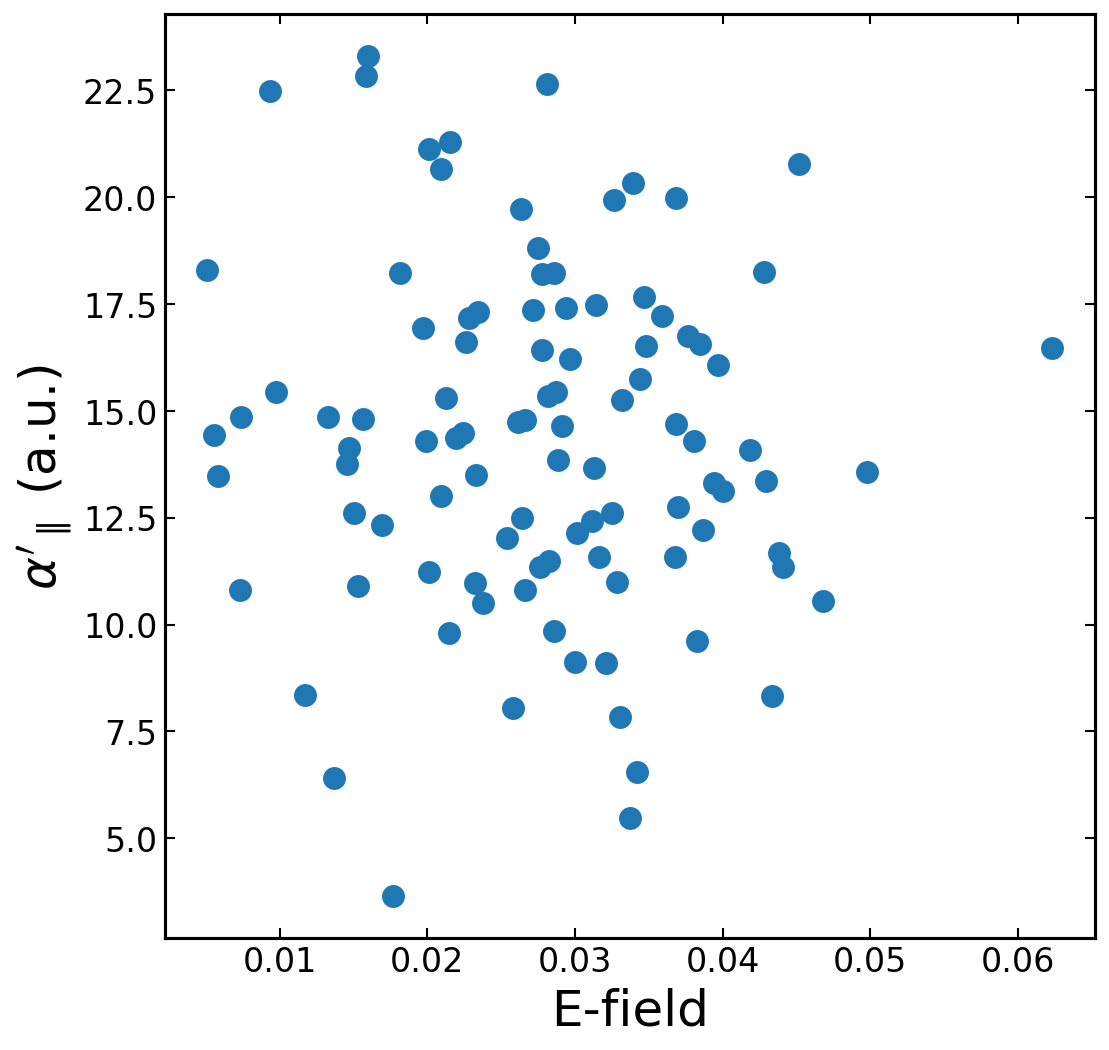

In [156]:
apol_deriv = [grab_apol_deriv(apar[j]) for j in range(0,100)]
fig = plt.figure(figsize=(8,8),dpi=150)
plt.plot(proj_values, apol_deriv, 'o')
plt.xlabel("E-field")
plt.ylabel("$\\alpha'_\parallel$ (a.u.)")
plt.show()



In [157]:
def polar_to_matrix(polar):
    pos = {'xx':0, 'yy':2, 'zz':5, 'yx':1, 'zx':3, 'zy':4}
    return np.array([[polar[:,pos['xx']], polar[:,pos['yx']], polar[:,pos['zx']]],
                     [polar[:,pos['yx']], polar[:,pos['yy']], polar[:,pos['zy']]],
                     [polar[:,pos['zx']], polar[:,pos['zy']], polar[:,pos['zz']]]]).T

In [158]:
test = polar_to_matrix(polar[0])


eigenvalues, eigenvectors = np.linalg.eig(polar_to_matrix(polar[0])[0])
D = np.diag(eigenvalues)
print(D.diagonal())

[68.54014927 73.0156125  77.20573822]


In [159]:
Ds = []
for i in range(16):
    eigenvalues, eigenvectors = np.linalg.eig(polar_to_matrix(polar[0])[i])
    Ds.append(np.sort(np.diag(eigenvalues).diagonal()))
Ds = np.array(Ds)

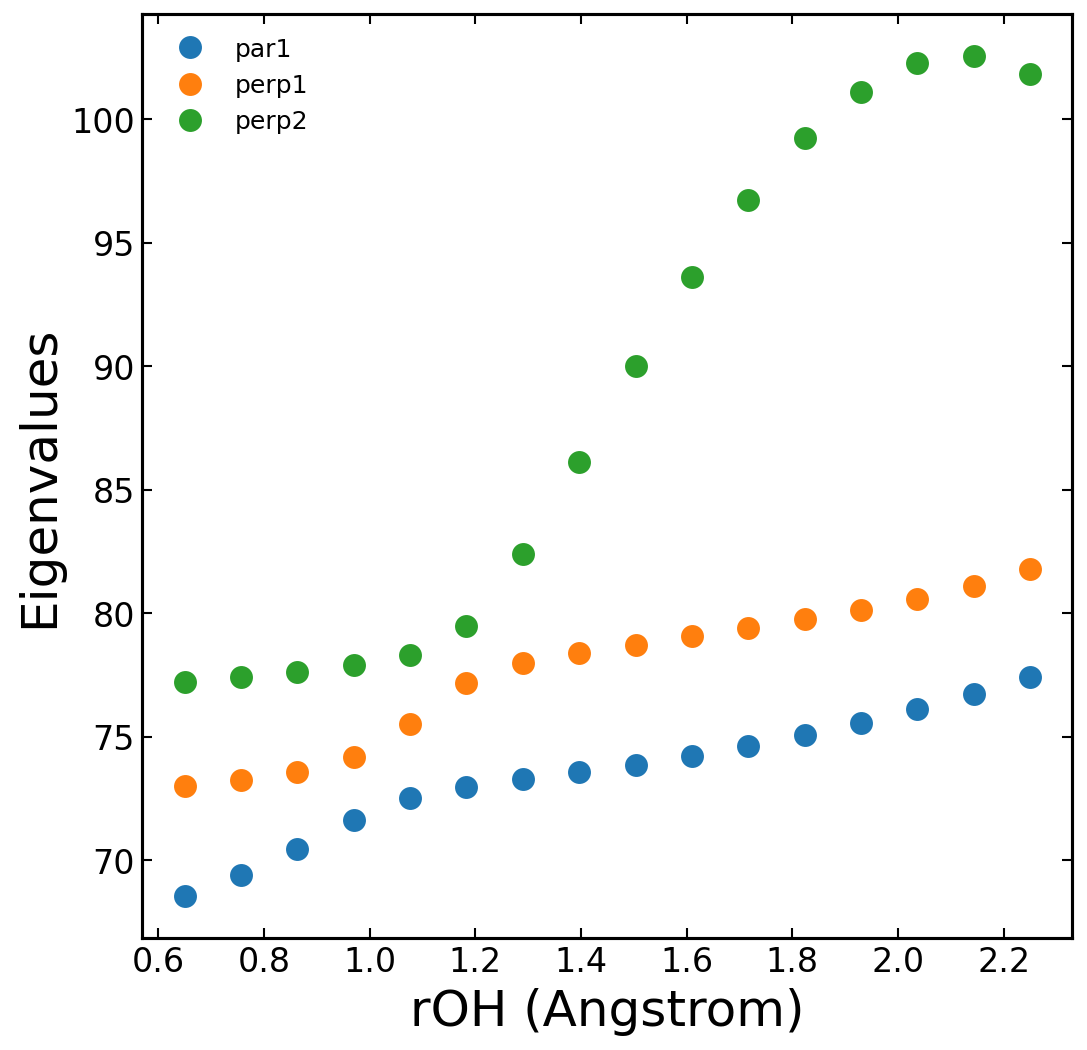

In [160]:
fig = plt.figure(figsize=(8,8),dpi=150)
labels = ['par1', 'perp1', 'perp2']
for i in range(3):
    plt.plot(rOH, Ds[:,i], 'o', label=labels[i])
plt.xlabel("rOH (Angstrom)")
plt.ylabel("Eigenvalues")
plt.legend(frameon=False)
plt.show()


Fit many elements

In [161]:
popt = {}
new_array = np.zeros((len(xvals), 6))
for i in range(6):
    popt[i], _ = curve_fit(quartic, rOH, polar[0][:,i])
    yvalues = quartic(xvals, *popt[i])
    new_array[:,i] = yvalues

newDs = []
for i in range(len(xvals)):
    eigenvalues, eigenvectors = np.linalg.eig(polar_to_matrix(new_array)[i])
    newDs.append(np.sort(np.diag(eigenvalues).diagonal()))
newDs = np.array(newDs)


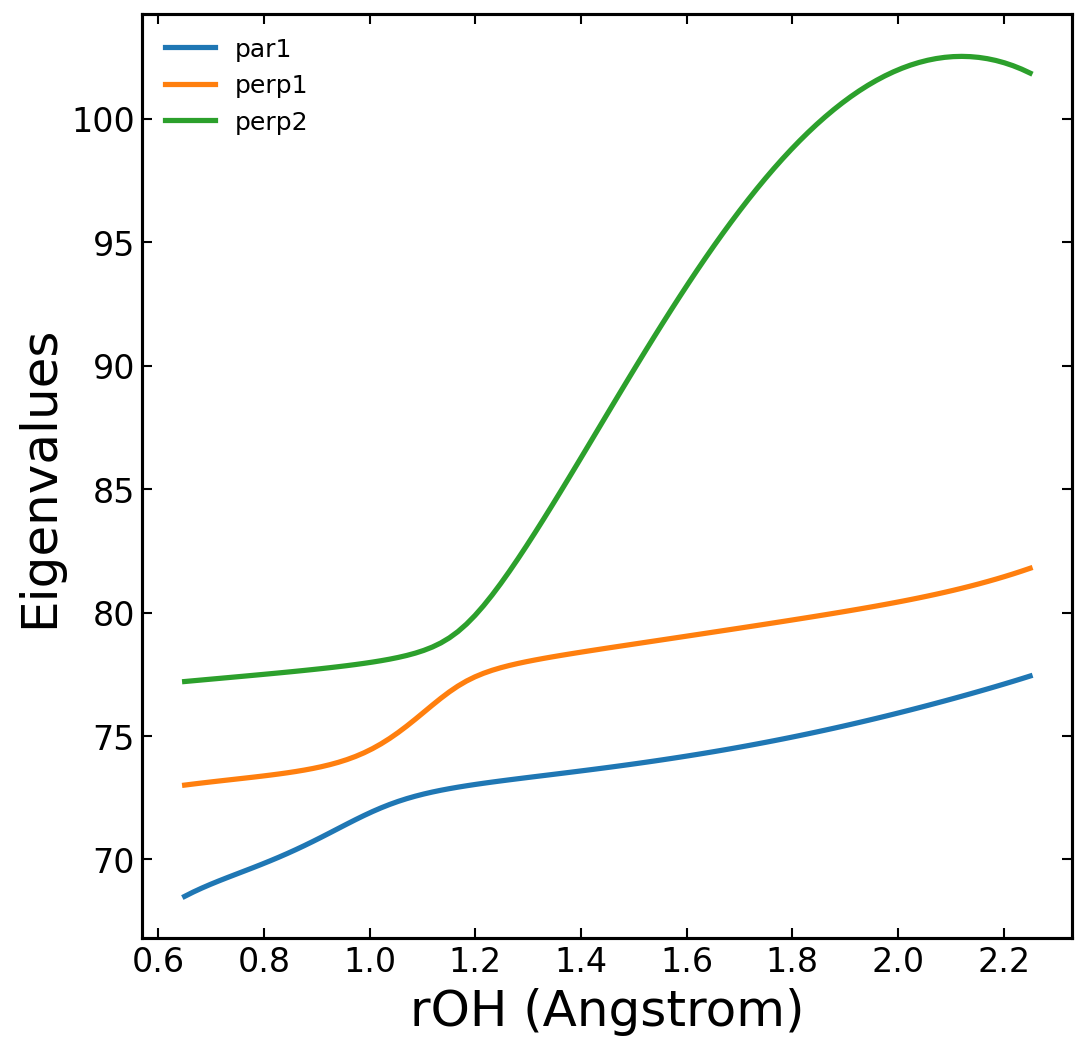

In [162]:
fig = plt.figure(figsize=(8,8),dpi=150)
labels = ['par1', 'perp1', 'perp2']
for i in range(3):
    plt.plot(xvals, newDs[:,i], label=labels[i])
plt.xlabel("rOH (Angstrom)")
plt.ylabel("Eigenvalues")
plt.legend(frameon=False)
plt.show()

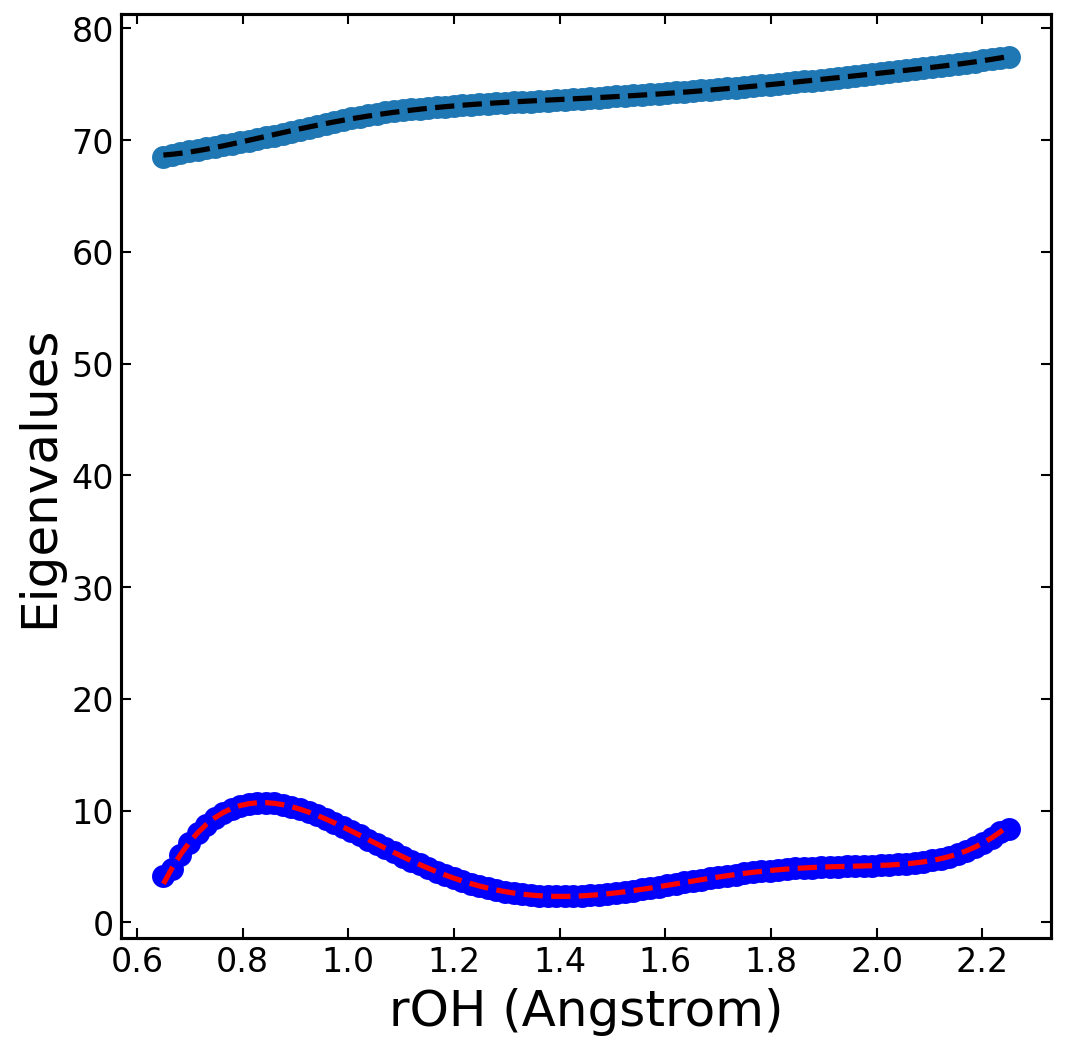

In [163]:
popt, pcov = curve_fit(quartic, xvals, newDs[:,0])
dpopt = poly_to_deriv_param(popt)
yvals = quartic(xvals, *popt)
yder = cubic(xvals, *dpopt)
fig = plt.figure(figsize=(8,8),dpi=150)
plt.plot(xvals, newDs[:,0], 'o')
plt.plot(xvals, numerical_derivative(xvals, yvals), 'o', color='blue')
plt.plot(xvals, yvals, '--', color='black')
plt.plot(xvals, yder, '--', color='red')
plt.xlabel("rOH (Angstrom)")
plt.ylabel("Eigenvalues")
plt.show()

In [164]:
deriv_dxx, deriv_dyy, deriv_dzz = [], [], []
for fr in range(100):
    popt = {}
    new_array = np.zeros((len(xvals), 6))
    for i in range(6):
        popt[i], _ = curve_fit(quartic, rOH, polar[fr][:,i])
        yvalues = quartic(xvals, *popt[i])
        new_array[:,i] = yvalues

    newDs = []
    for i in range(len(xvals)):
        eigenvalues, eigenvectors = np.linalg.eig(polar_to_matrix(new_array)[i])
        newDs.append(np.sort(np.diag(eigenvalues).diagonal()))
    newDs = np.array(newDs)

    popt, pcov = curve_fit(quartic, xvals, newDs[:,0])
    dpopt = poly_to_deriv_param(popt)
    deriv_dxx.append(cubic(r0, *dpopt))

    popt, pcov = curve_fit(quartic, xvals, newDs[:,1])
    dpopt = poly_to_deriv_param(popt)
    deriv_dyy.append(cubic(r0, *dpopt))

    popt, pcov = curve_fit(quartic, xvals, newDs[:,2])
    dpopt = poly_to_deriv_param(popt)
    deriv_dzz.append(cubic(r0, *dpopt))


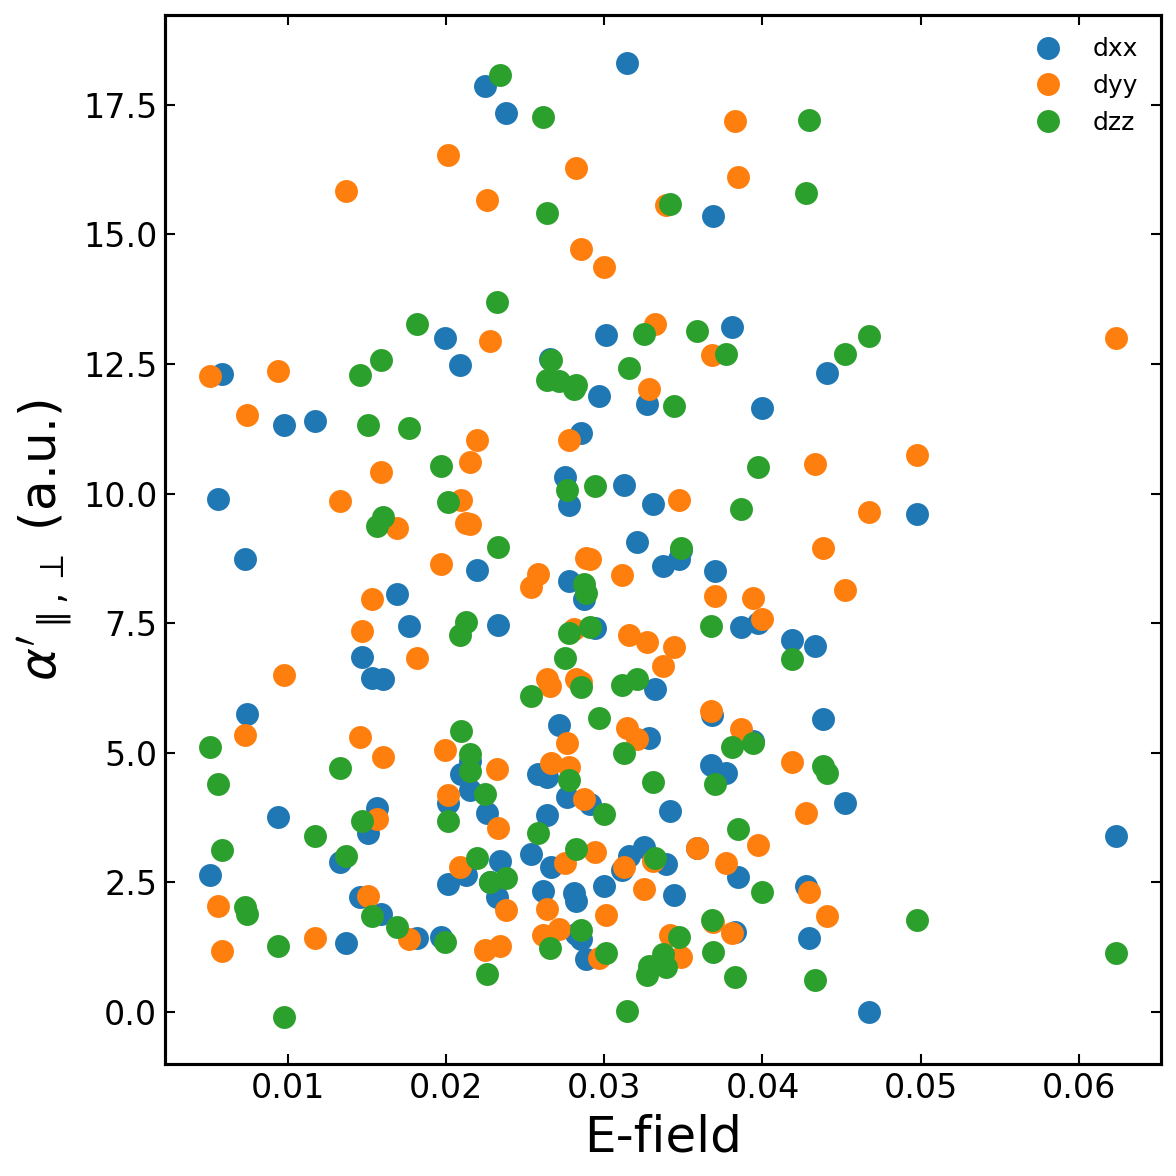

In [165]:
fig = plt.figure(figsize=(8,8),dpi=150)
plt.plot(proj_values, deriv_dxx, 'o', label='dxx')
plt.plot(proj_values, deriv_dyy, 'o', label='dyy')
plt.plot(proj_values, deriv_dzz, 'o', label='dzz')
plt.xlabel("E-field")
plt.ylabel("$\\alpha'_{\parallel,\perp}$ (a.u.)")
plt.tight_layout()
plt.legend(frameon=False)
plt.show()

In [166]:
def bond_polar_model(pol_tensor, bond_vector):
    parallel_component = np.dot(pol_tensor, bond_vector)
    print(parallel_component.shape)
    parallel_component = np.outer(parallel_component, bond_vector)
    print(parallel_component.shape)

    perpendicular_component = pol_tensor - parallel_component
    perpendicular_component *= 2
    return parallel_component, perpendicular_component

In [167]:
def iso_pol(pol):
    return (pol[0,0] + pol[1,1] + pol[2,2])/3

(100, 3)


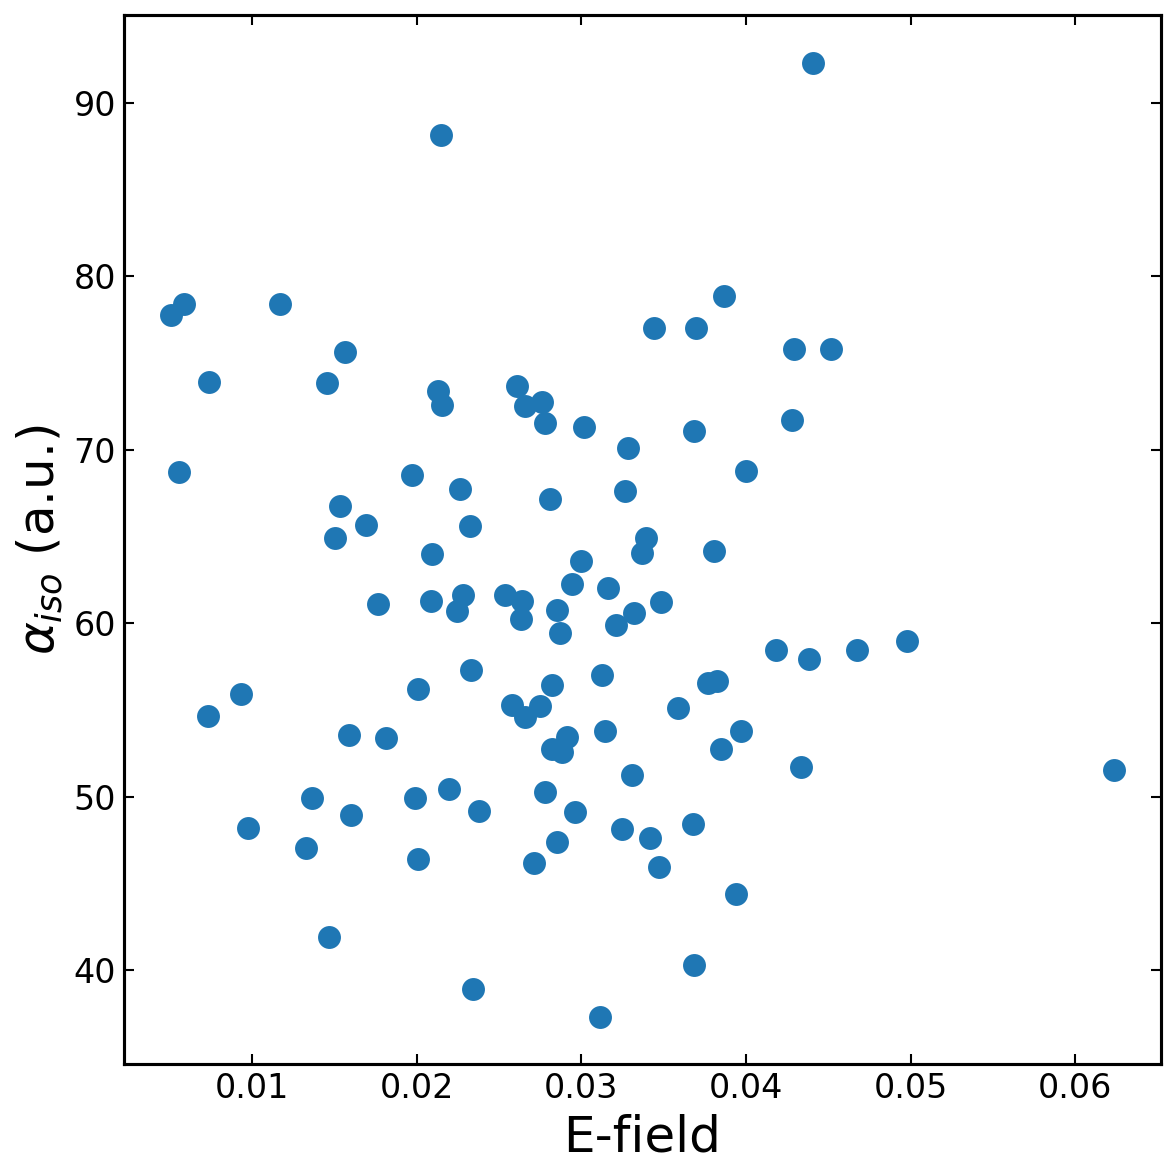

In [285]:
testmat = polar_to_matrix(polar[0])
testmat[0]
iso = [iso_pol(polar_to_matrix(pol)) for pol in polar.values()]
iso = np.array(iso)
print(iso.shape)
iso = np.sum(iso,axis=1)

fig = plt.figure(figsize=(8,8),dpi=150)
plt.plot(proj_values, iso, 'o')
plt.xlabel("E-field")
plt.ylabel("$\\alpha_{iso}$ (a.u.)")
plt.tight_layout()
plt.show()


In [169]:
def sphere_angle(eOH):
    x, y, z = eOH
    theta = np.arccos(z)
    if x > 0:
        phi = np.arctan(y / x)
    elif x < 0:
        phi = np.arctan(y / x) + np.pi
    elif x == 0 and y > 0:
        phi = np.pi / 2
    elif x == 0 and y < 0:
        phi = 3 * np.pi / 2
    else:  # x = 0 and y = 0
        phi = 0
    return theta, phi

def sphere_angle(eOH):
    x, y, z = eOH
    theta = np.arctan2(np.sqrt(x**2 + y**2), z)
    phi = np.arctan2(y, x)
    return theta, phi

def alt_perp(azz, axy, eOH):
    theta, phi = sphere_angle(eOH)
    return azz - axy/(np.tan(theta)**2*np.cos(phi)*np.sin(phi))

def alt_para(aperp, axy, eOH):
    theta, phi = sphere_angle(eOH)
    return aperp + axy/(np.sin(theta)**2*np.cos(phi)*np.sin(phi))

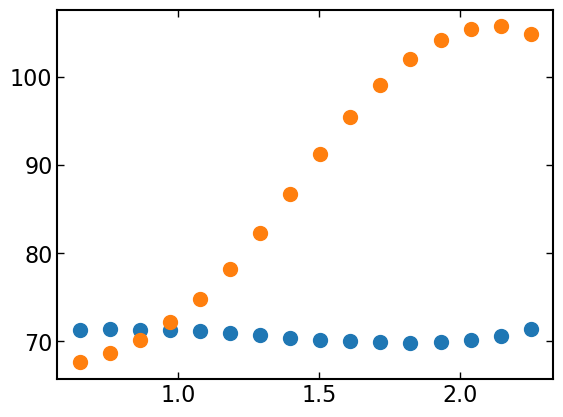

In [170]:
azz = polar[0][:,5]
axy = polar[0][:,1]

aperp = alt_perp(azz, axy, eOHs[0])
apara = alt_para(aperp, axy, eOHs[0])
fig = plt.figure()
plt.plot(rOH, aperp, 'o')
plt.plot(rOH, apara, 'o')
plt.show()


In [171]:
aparas = []
aperps = []
for i in range(100):
    azz = polar[i][:,5]
    axy = polar[i][:,1]
    aperp = alt_perp(azz, axy, eOHs[i])
    apara = alt_para(aperp, axy, eOHs[i])
    popt, pcov = curve_fit(quartic, rOH, aperp)
    dpopt = poly_to_deriv_param(popt)
    aperp = cubic(r0, *dpopt)
    popt, pcov = curve_fit(quartic, rOH, apara)
    dpopt = poly_to_deriv_param(popt)
    apara = cubic(r0, *dpopt)
    aparas.append(apara)
    aperps.append(aperp)
    if apara > 30:
        print(i, apara)
aparas = np.array(aparas)
aperps = np.array(aperps)
msk1 = (aparas>-20) & (aparas<20)
msk2 = (aperps>-20) & (aperps<20)
print(np.average(aparas[msk1])/np.average(aperps[msk2]))

1 32.37495585795907
13 59.6866466643
27 66.77071180554907
39 43.912860612347515
52 33.166895908051345
68 855.214716590006
78 52.30579694247964
7.870507372218048


eOH: [-5.62541664e-01 -7.23325124e-04 -8.26768577e-01]
theta: 2.5441352570359608, phi: -3.1403068382064023
tan(theta): -0.6804106303265944, cos(theta): -0.8267686074347729, sin(theta): 0.5625421493189345
cos(phi): -0.9999991733395138, sin(phi): -0.0012858150290799668
denom_tantancossin: 0.0005952786668810817
denom_sinsin: 0.0004069005482165047
eOH: [-0.61916262 -0.03599092  0.78443754]
theta: 0.6690075800547292, phi: -3.0835296054839434
tan(theta): 0.79064011437657, cos(theta): 0.7844375586670479, sin(theta): 0.6202078011057921
cos(phi): -0.9983148147433656, sin(phi): -0.058030428775942035
denom_tantancossin: 0.03621437428677538
denom_sinsin: 0.022284235767247453


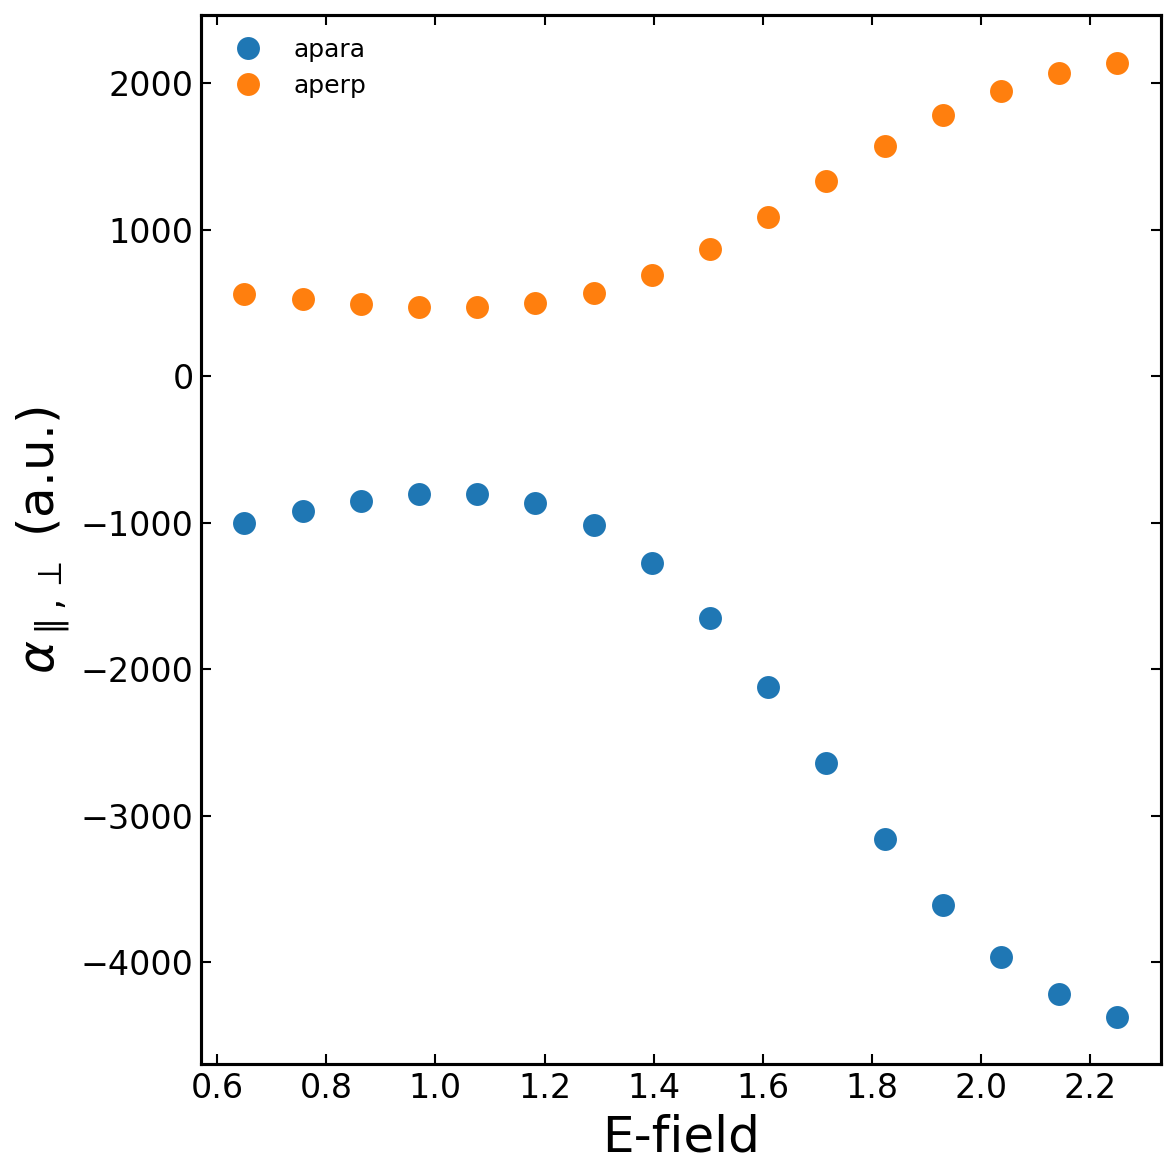

In [172]:
def print_data(i):
    theta, phi = sphere_angle(eOHs[i])
    print(f"eOH: {eOHs[i]}")
    print(f"theta: {theta}, phi: {phi}")
    tantheta = np.tan(theta)
    costheta = np.cos(theta)
    sintheta = np.sin(theta)
    cosphi = np.cos(phi)
    sinphi = np.sin(phi)
    print(f"tan(theta): {tantheta}, cos(theta): {costheta}, sin(theta): {sintheta}")
    print(f"cos(phi): {cosphi}, sin(phi): {sinphi}")
    print(f"denom_tantancossin: {tantheta**2*cosphi*sinphi}")
    print(f"denom_sinsin: {sintheta**2*cosphi*sinphi}")

print_data(68)
print_data(67)

aperp = alt_perp(azz, axy, eOHs[68])
apara = alt_para(aperp, axy, eOHs[68])


fig = plt.figure(figsize=(8,8),dpi=150)
plt.plot(rOH, aperp, 'o', label='apara')
plt.plot(rOH, apara, 'o', label='aperp')
plt.xlabel("E-field")
plt.ylabel("$\\alpha_{\parallel,\perp}$ (a.u.)")
plt.tight_layout()
plt.legend(frameon=False)
plt.show()

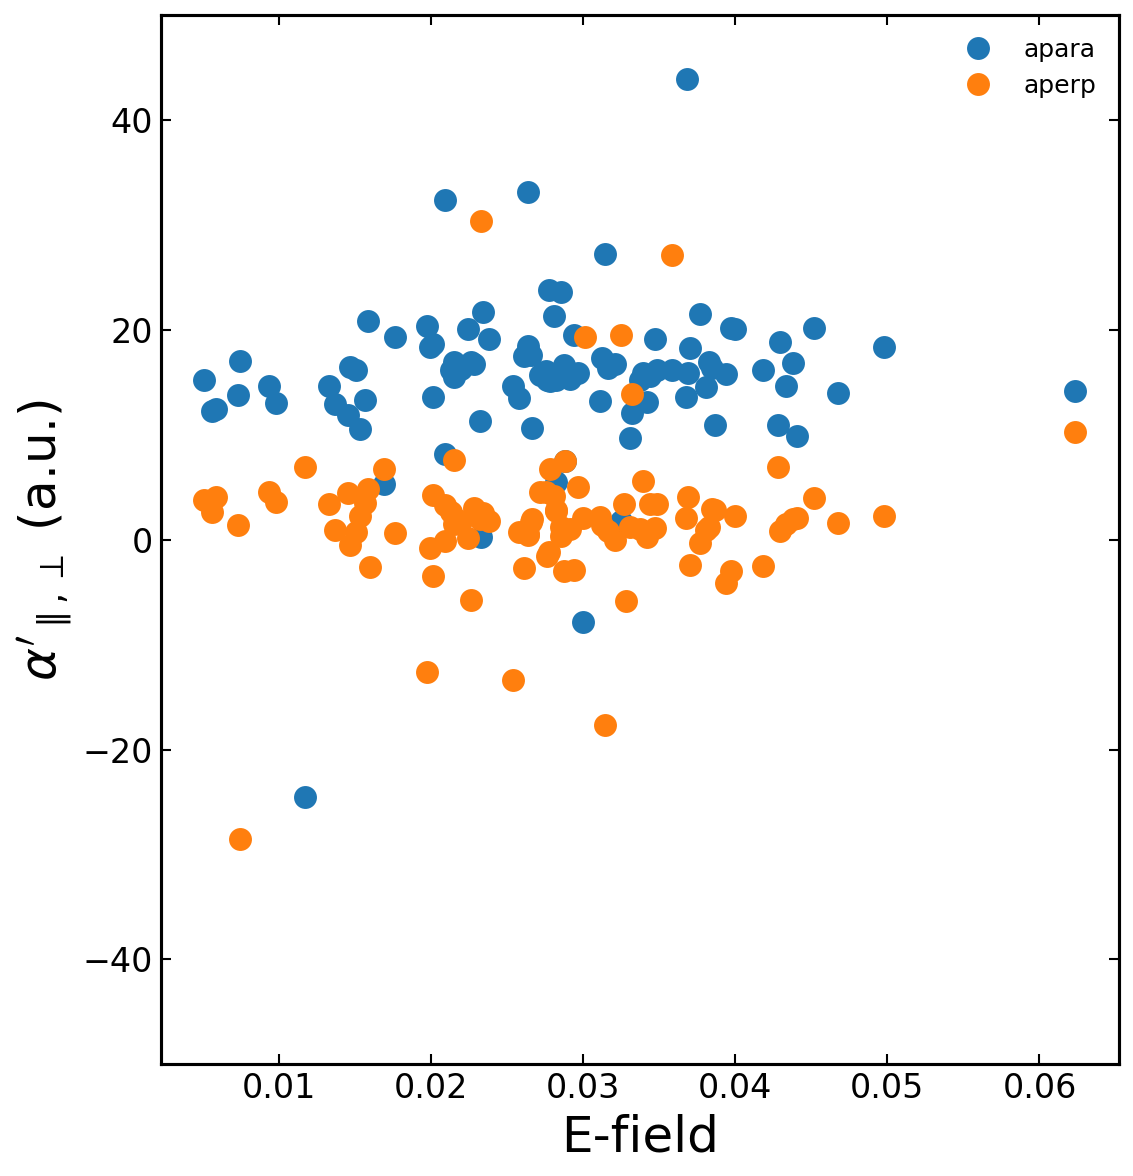

In [173]:
fig = plt.figure(figsize=(8,8),dpi=150)
plt.plot(proj_values, aparas, 'o', label='apara')
plt.plot(proj_values, aperps, 'o', label='aperp')
plt.xlabel("E-field")
plt.ylabel("$\\alpha'_{\parallel,\perp}$ (a.u.)")
plt.tight_layout()
plt.legend(frameon=False)
plt.ylim(-50, 50)
plt.show()

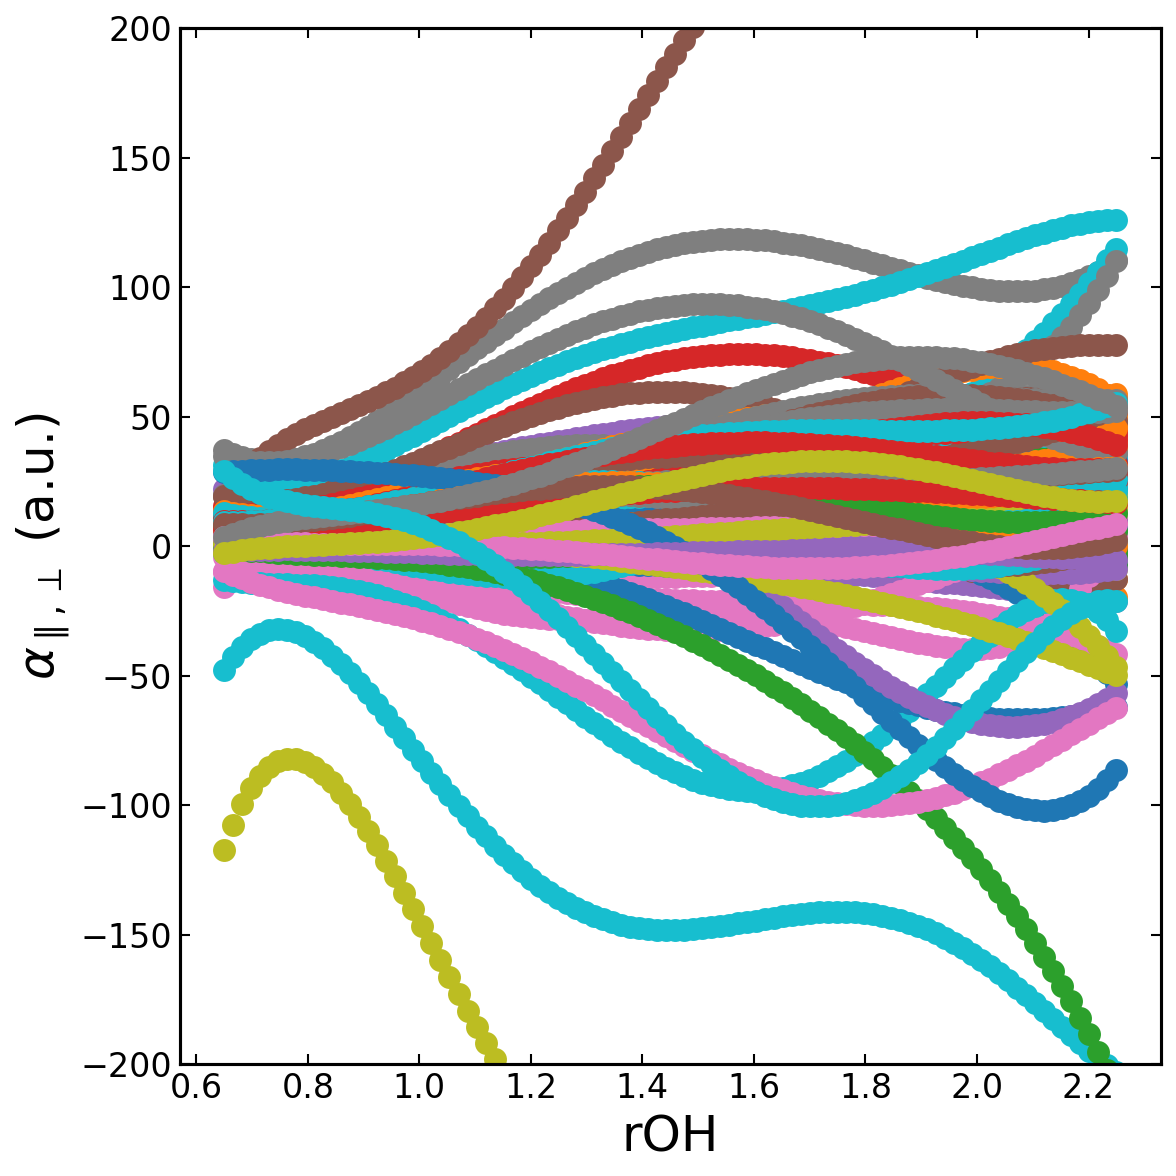

In [174]:
fig = plt.figure(figsize=(8,8),dpi=150)
xvals = np.linspace(0.65, 2.25, 100)
for i in range(100):

    azz = polar[i][:,5]
    axy = polar[i][:,1]

    aperp = alt_perp(azz, axy, eOHs[i])
    apara = alt_para(aperp, axy, eOHs[i])

    popt, pcov = curve_fit(quartic, rOH, aperp)
    yperp = quartic(xvals, *popt)
    dpoptperp = poly_to_deriv_param(popt)
    dyperp = cubic(xvals, *dpoptperp)

    popt, pcov = curve_fit(quartic, rOH, apara)
    ypara = quartic(xvals, *popt)
    dpoptpara = poly_to_deriv_param(popt)
    dypara = cubic(xvals, *dpoptpara)

    plt.plot(xvals, dyperp, 'o', label='apara')
    plt.plot(xvals, dypara, 'o', label='aperp')
plt.xlabel("rOH")
plt.ylabel("$\\alpha_{\parallel,\perp}$ (a.u.)")
plt.ylim(-200,200)
plt.tight_layout()
plt.show()

In [175]:
aparas = []
aperps = []
for i in range(100):
    azz = polar[i][:,5]
    axy = polar[i][:,1]
    aperp = alt_perp(azz, axy, eOHs[i])
    apara = alt_para(aperp, axy, eOHs[i])
    popt, pcov = curve_fit(quartic, rOH, aperp)

    aperp = quartic(r0, *popt)
    
    popt, pcov = curve_fit(quartic, rOH, apara)

    apara = quartic(r0, *popt)
    aparas.append(apara)
    aperps.append(aperp)
    
aparas = np.array(aparas)
aperps = np.array(aperps)

print(np.average(aparas)/np.average(aperps))


5.27763813827959


In [176]:
pol_gas = np.genfromtxt("../example_potential/scan_polarizability.dat")
pol_gas.shape
eoh_gas = np.genfromtxt("../example_potential/scan_eOHs.dat")
eoh_gas.shape

(3,)

[   9.78727215  -95.24931444 -313.19852866]
[    9.13940971  -300.09291707 -4193.39362934]


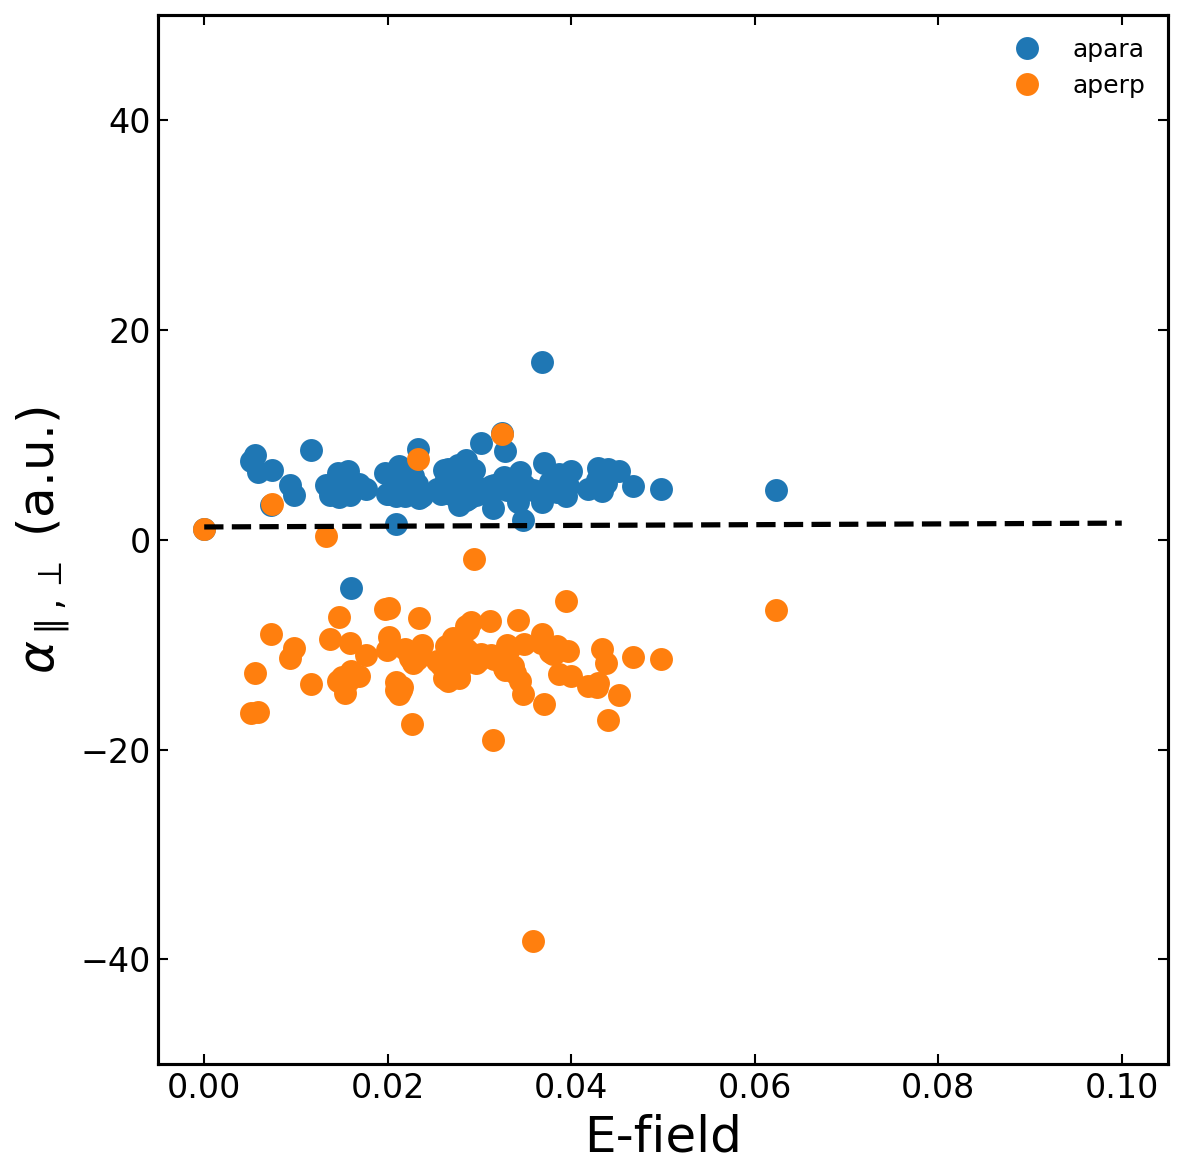

11.939762911765948
-5.424813662864057


In [195]:
def quadratic(x, a, b, c):
    return a + b*x + c*x**2

def linear(x, a, b):
    return a + b*x

azz_gas = pol_gas[:,5]
axy_gas = pol_gas[:,1]

perp_gas = alt_perp(azz_gas, axy_gas, eoh_gas)
para_gas = alt_para(perp_gas, axy_gas, eoh_gas)

popt_gas, pcov_gas = curve_fit(quadratic, rOH, perp_gas)
perp_gas = quadratic(r0, *popt_gas)

popt_gas, pcov_gas = curve_fit(quadratic, rOH, para_gas)
para_gas = quadratic(r0, *popt_gas)

popt, pcov = curve_fit(quadratic, proj_values, aparas/para_gas)
print(popt)

popt, pcov = curve_fit(quadratic, proj_values, aperps/perp_gas)
print(popt)

xp = np.linspace(0, 0.1, 100)
yv = linear(xp, 1.2142, 3.6206)

newparas = np.append(aparas, para_gas)
newperps = np.append(aperps, perp_gas)
new_proj = np.append(proj_values, 0.0)

fig = plt.figure(figsize=(8,8),dpi=150)
plt.plot(new_proj, newparas/newparas[-1], 'o', label='apara')
plt.plot(new_proj, newperps/newperps[-1], 'o', label='aperp')
plt.plot(xp, yv, '--', color='black')
plt.xlabel("E-field")
plt.ylabel("$\\alpha_{\parallel,\perp}$ (a.u.)")
plt.tight_layout()
plt.legend(frameon=False)
plt.ylim(-50,50)
plt.show()
print(para_gas)
print(perp_gas)


In [203]:
uu = np.outer(eoh_gas, eoh_gas)
uu

array([[ 0.00363277, -0.02906338,  0.05267727],
       [-0.02906338,  0.23251678, -0.42143571],
       [ 0.05267727, -0.42143571,  0.7638505 ]])

In [211]:
ux = np.dot(eoh_gas, [1,0,0])
uy = np.dot(eoh_gas, [0,1,0])
uz = np.dot(eoh_gas, [0,0,1])
print(ux, uy, uz)
axx_gas = pol_gas[:,0]

print(5.6*azz_gas[0]/(1 + 4.6*uz**2))
print(5.6*axx_gas[0]/(1 + 4.6*ux**2))
print(axy_gas[0]*5.6/(4.6*ux*uy))


0.06027247756719589 -0.48219993710517883 0.8739854097366333
6.032418171400667
32.7949871959322
12.370664760469223


In [216]:
axx_gas/azz_gas
print(axx_gas[0]/azz_gas[0], (4.6*ux**2 + 1)/(4.6*uz**2 + 1))

1.2245585891305464 0.2252493480446347


In [278]:
test = pickle.load(open('../example_maps/doh_d2o_gas.pckl', 'rb'))
x01 = test.x01
x01 = x01[:100]
w01 = test.w01
w01 = w01[:100]
eproj = test.Eproj
eproj = eproj[:100]


In [265]:
def alpha_from_x01(x01, eOH, i, j):
    return x01*(4.6*np.dot(eOH,i)*np.dot(eOH,j) + np.dot(i,j))

ivec = [1,0,0]
jvec = [0,1,0]
kvec = [0,0,1]

In [263]:
print(alpha_from_x01(x01[0], eoh_gas, kvec, kvec))

all_eOHs = np.array(list(eOHs.values()))
avals = []
for i in range(100):
    avals.append(alpha_from_x01(x01[i], all_eOHs[i], kvec, kvec))

0.6027537143846813
68.2146
113.171596245801


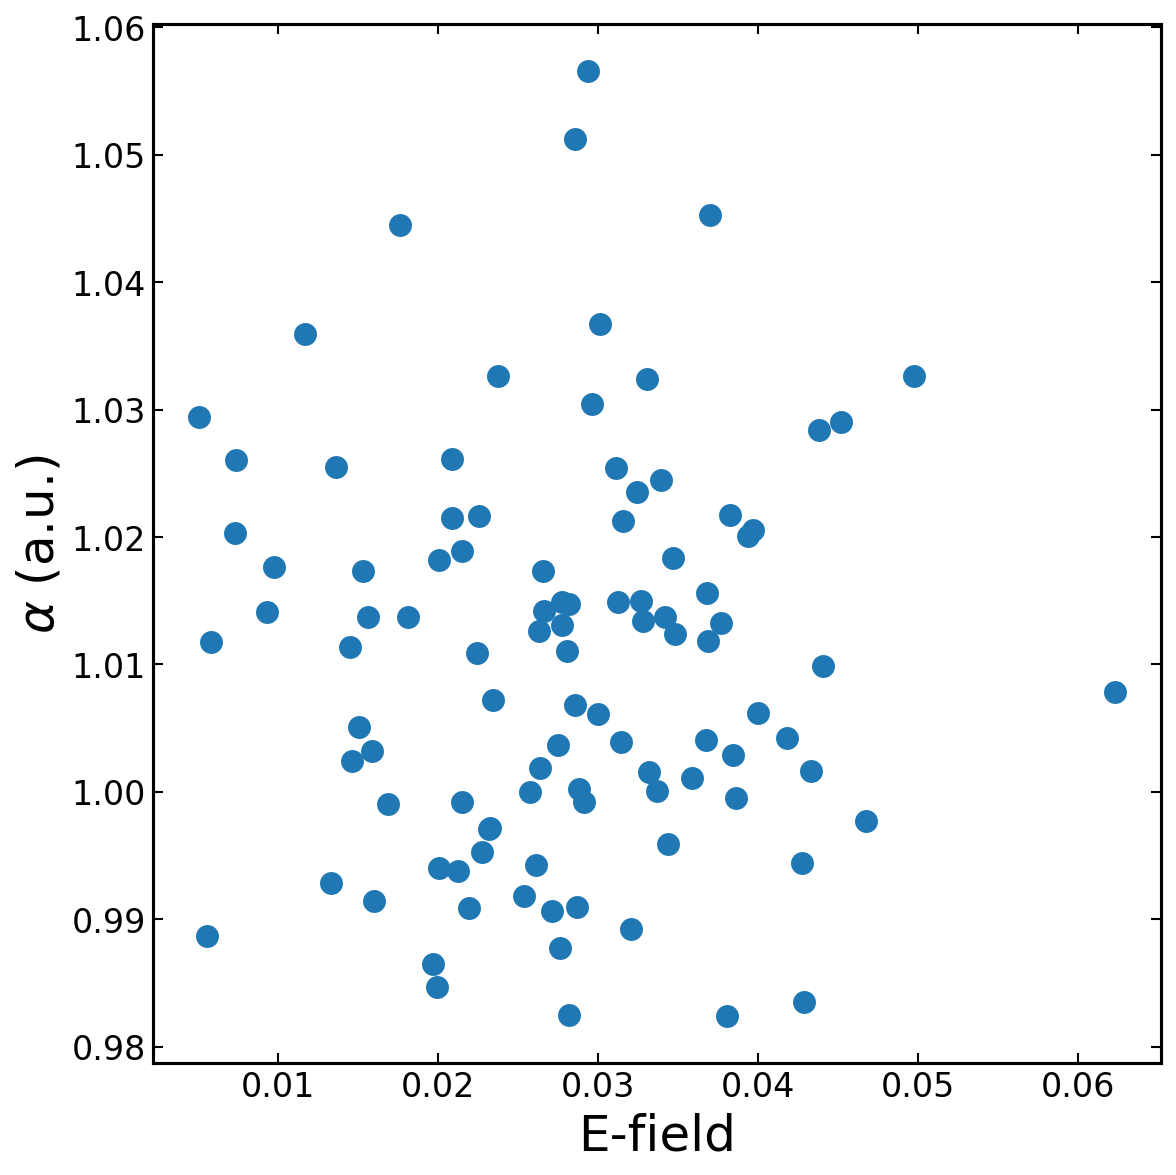

In [255]:
fig = plt.figure(figsize=(8,8),dpi=150)
plt.plot(proj_values, avals, 'o')
plt.xlabel("E-field")
plt.ylabel("$\\alpha$ (a.u.)")
plt.tight_layout()
plt.show()


In [271]:
azz_pred = alpha_from_x01(x01[0], all_eOHs[0], ivec, ivec)
polar[0][:,0]/azz_pred, azz_pred

(array([159.89873432, 161.07817751, 162.5894708 , 164.56637463,
        167.16971208, 170.51793767, 174.58243598, 179.1149849 ,
        183.72495073, 188.05208976, 191.87812627, 195.10523544,
        197.68616857, 199.55260359, 200.563238  , 200.50556351]),
 0.4508059448137938)

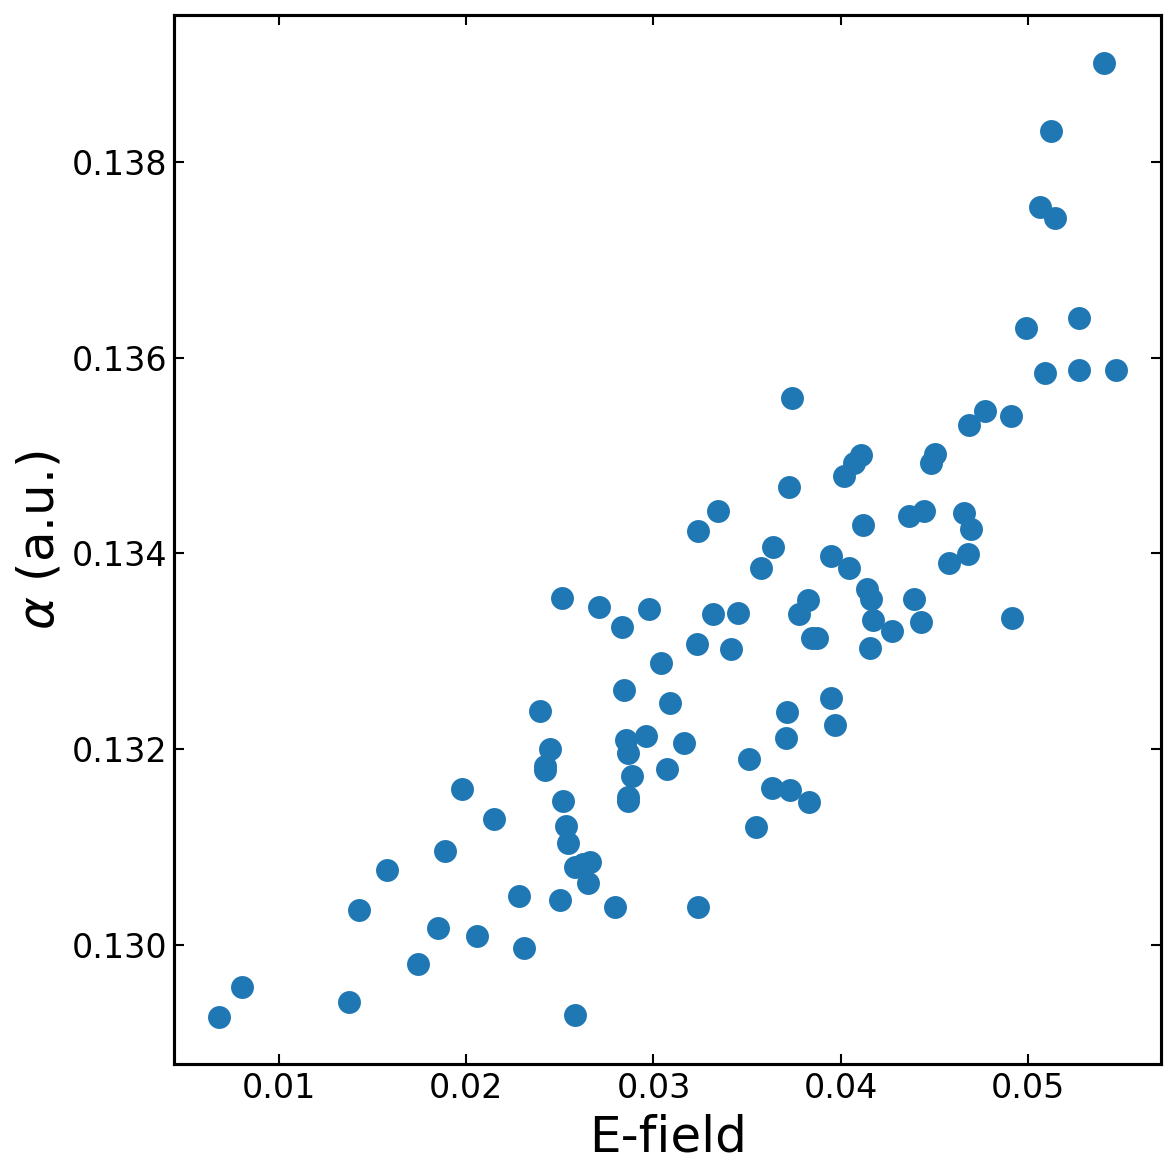

In [280]:
fig = plt.figure(figsize=(8,8),dpi=150)
plt.plot(eproj, x01, 'o')
plt.xlabel("E-field")
plt.ylabel("$\\alpha$ (a.u.)")
plt.tight_layout()
plt.show()

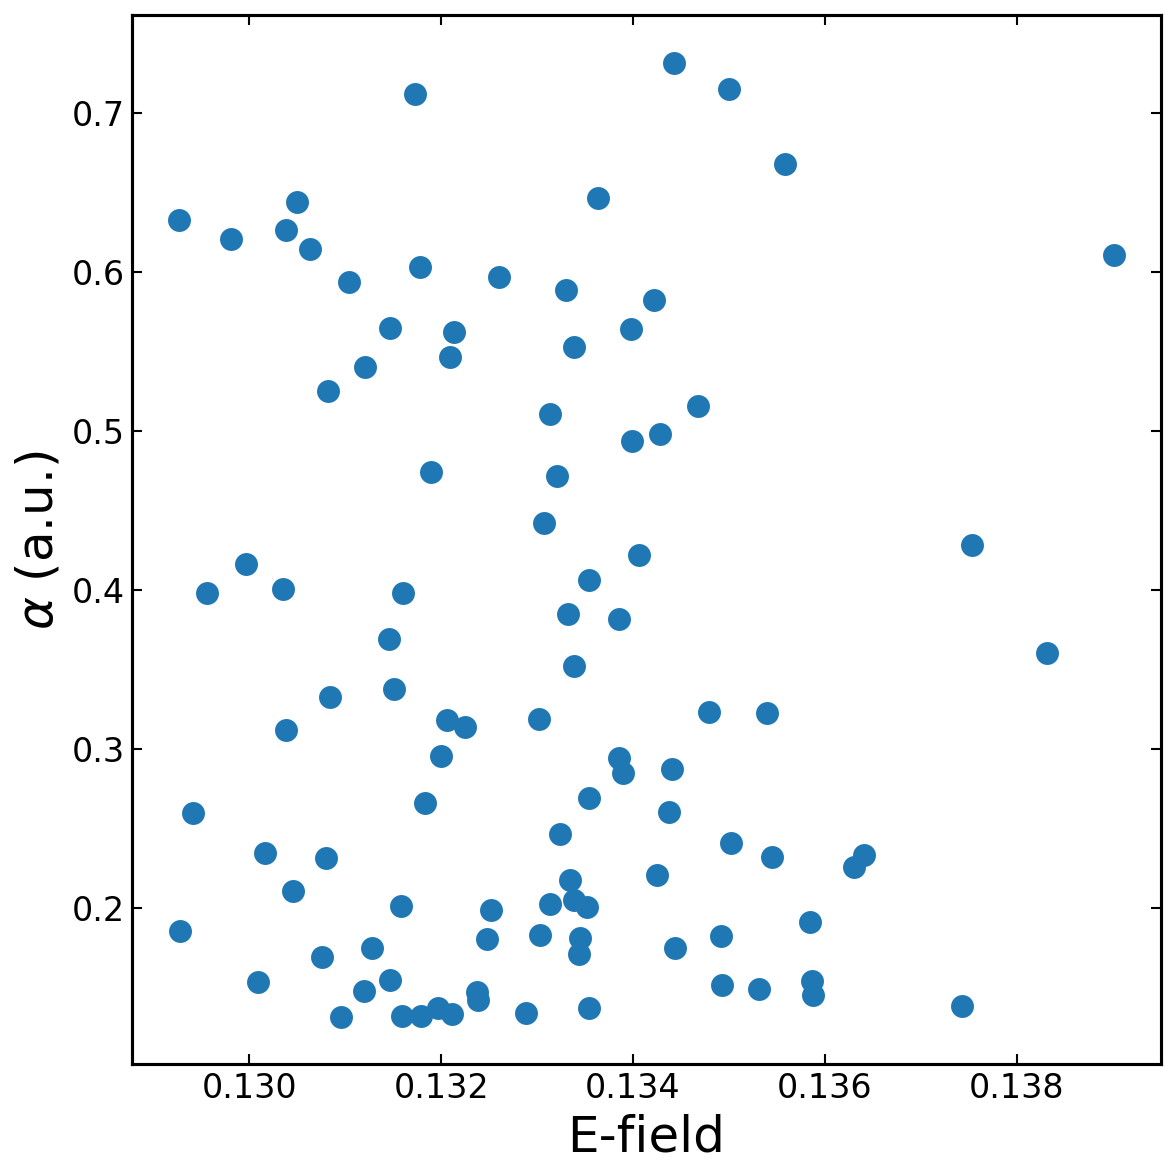

In [283]:
fig = plt.figure(figsize=(8,8),dpi=150)
plt.plot(x01, avals, 'o')
plt.xlabel("E-field")
plt.ylabel("$\\alpha$ (a.u.)")
plt.tight_layout()
plt.show()


In [296]:
all_iso = []
for key in polar:
    iso = (polar[key][:,0] + polar[key][:,2] + polar[key][:,5])/3
    all_iso.append(iso)

all_iso = np.array(all_iso)
print(all_iso.shape)

(100, 16)


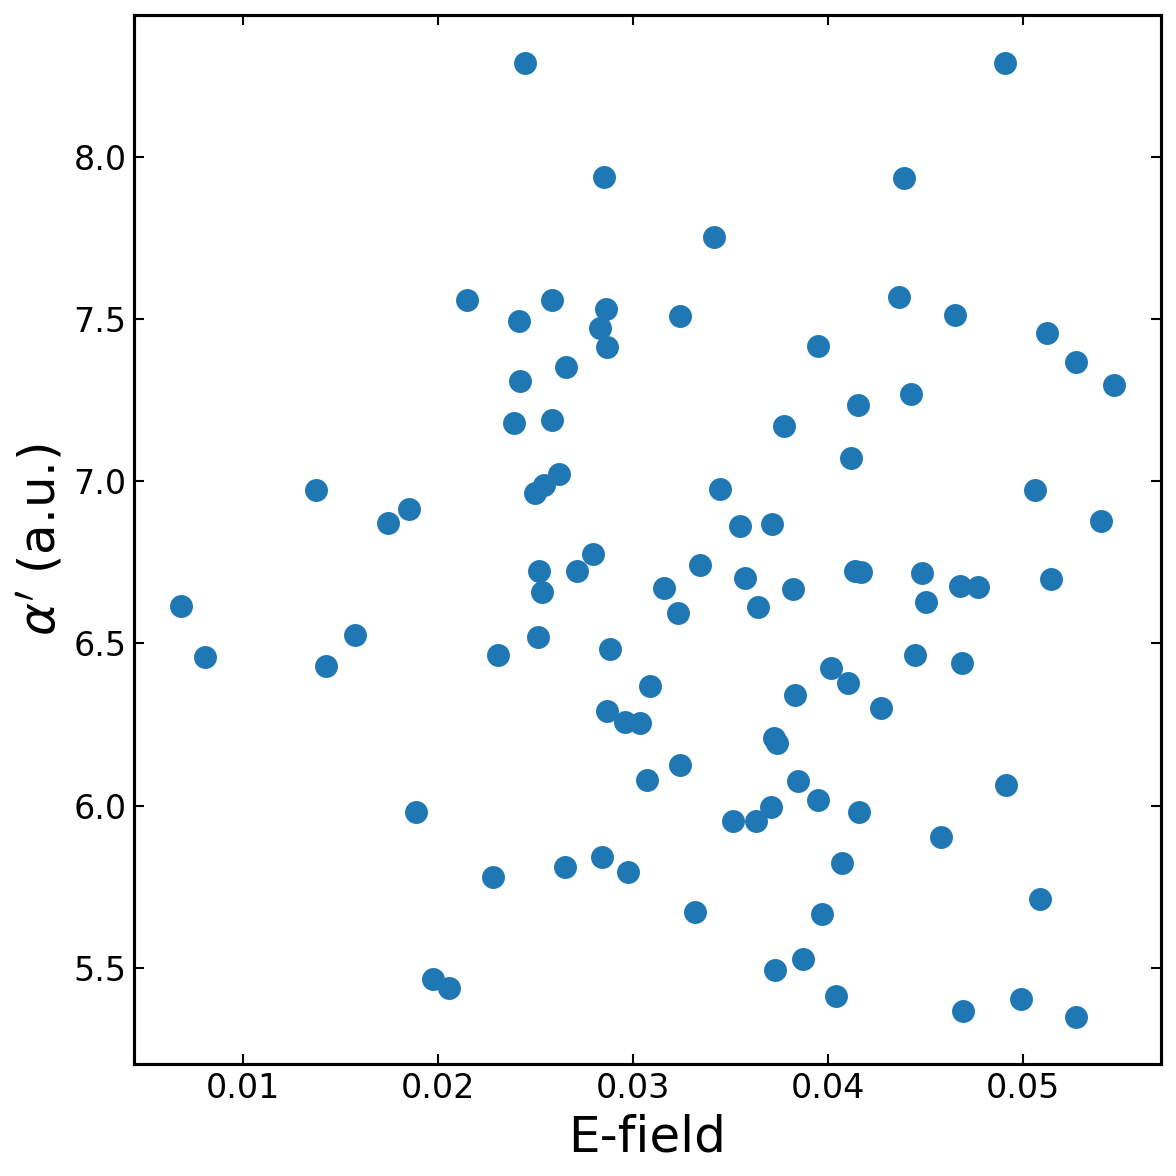

In [301]:
dlocs = []
for iso in all_iso:
    popt, pcov = curve_fit(quartic, rOH, iso)
    dpopt = poly_to_deriv_param(popt)
    dloc = cubic(r0, *dpopt)
    dlocs.append(dloc)

fig = plt.figure(figsize=(8,8),dpi=150)
plt.plot(eproj, dlocs, 'o')
plt.xlabel("E-field")
plt.ylabel("$\\alpha'$ (a.u.)")
plt.tight_layout()
plt.show()

